# Improving Word2vec Algorithms

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
##from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import bz2
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import nltk # standard preprocessing
##import operator # sorting items in dictionary by value
#nltk.download() #tokenizers/punkt/PY3/english.pickle
from math import ceil
import csv

c:\users\thushan\documents\python_virtualenvs\tensorflow_venv\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Dataset
This code downloads a [dataset](http://www.evanjones.ca/software/wikipedia2text.html) consisting of several Wikipedia articles totaling up to roughly 61 megabytes. Additionally the code makes sure the file has the correct size after downloading it.

In [2]:
url = 'http://www.evanjones.ca/software/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('wikipedia2text-extracted.txt.bz2', 18377035)

Found and verified wikipedia2text-extracted.txt.bz2


## Read Data with Preprocessing with NLTK
Reads data as it is to a string, convert to lower-case and tokenize it using the nltk library. This code reads data in 1MB portions as processing the full text at once slows down the task and returns a list of words.

In [3]:
def read_data(filename):
  """
  Extract the first file enclosed in a zip file as a list of words
  and pre-processes it using the nltk python library
  """

  with bz2.BZ2File(filename) as f:

    data = []
    file_size = os.stat(filename).st_size
    chunk_size = 1024 * 1024 # reading 1 MB at a time as the dataset is moderately large
    print('Reading data...')
    for i in range(ceil(file_size//chunk_size)+1):
        bytes_to_read = min(chunk_size,file_size-(i*chunk_size))
        file_string = f.read(bytes_to_read).decode('utf-8')
        file_string = file_string.lower()
        # tokenizes a string to words residing in a list
        file_string = nltk.word_tokenize(file_string)
        data.extend(file_string)
  return data

words = read_data(filename)
print('Data size %d' % len(words))
token_count = len(words)

print('Example words (start): ',words[:10])
print('Example words (end): ',words[-10:])

Reading data...
Data size 3360286
Example words (start):  ['propaganda', 'is', 'a', 'concerted', 'set', 'of', 'messages', 'aimed', 'at', 'influencing']
Example words (end):  ['favorable', 'long-term', 'outcomes', 'for', 'around', 'half', 'of', 'those', 'diagnosed', 'with']


## Building the Dictionaries
Builds the following. To understand each of these elements, let us also assume the text "I like to go to school"

* `dictionary`: maps a string word to an ID (e.g. {I:0, like:1, to:2, go:3, school:4})
* `reverse_dictionary`: maps an ID to a string word (e.g. {0:I, 1:like, 2:to, 3:go, 4:school}
* `count`: List of list of (word, frequency) elements (e.g. [(I,1),(like,1),(to,2),(go,1),(school,1)]
* `data` : Contain the string of text we read, where string words are replaced with word IDs (e.g. [0, 1, 2, 3, 2, 4])

It also introduces an additional special token `UNK` to denote rare words to are too rare to make use of.

In [4]:
# we restrict our vocabulary size to 50000
vocabulary_size = 50000 

def build_dataset(words):
  count = [['UNK', -1]]
  # Gets only the vocabulary_size most common words as the vocabulary
  # All the other words will be replaced with UNK token
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()

  # Create an ID for each word by giving the current length of the dictionary
  # And adding that item to the dictionary
  for word, _ in count:
    dictionary[word] = len(dictionary)
    
  data = list()
  unk_count = 0
  # Traverse through all the text we have and produce a list
  # where each element corresponds to the ID of the word found at that index
  for word in words:
    # If word is in the dictionary use the word ID,
    # else use the ID of the special token "UNK"
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
    
  # update the count variable with the number of UNK occurences
  count[0][1] = unk_count
  
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  # Make sure the dictionary is of size of the vocabulary
  assert len(dictionary) == vocabulary_size
    
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 69215], ('the', 226881), (',', 184013), ('.', 120944), ('of', 116323)]
Sample data [1721, 9, 8, 16822, 223, 4, 5167, 4479, 26, 11851]


## Generating Batches of Data for Skip-Gram
Generates a batch or target words (`batch`) and a batch of corresponding context words (`labels`). It reads `2*window_size+1` words at a time (called a `span`) and create `2*window_size` datapoints in a single span. The function continue in this manner until `batch_size` datapoints are created. Everytime we reach the end of the word sequence, we start from beginning. 

In [5]:
data_index = 0

def generate_batch_skip_gram(batch_size, window_size):
  # data_index is updated by 1 everytime we read a data point
  global data_index 
    
  # two numpy arras to hold target words (batch)
  # and context words (labels)
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
  # span defines the total window size, where
  # data we consider at an instance looks as follows. 
  # [ skip_window target skip_window ]
  span = 2 * window_size + 1 
    
  # The buffer holds the data contained within the span
  buffer = collections.deque(maxlen=span)
  
  # Fill the buffer and update the data_index
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  
  # This is the number of context words we sample for a single target word
  num_samples = 2*window_size 

  # We break the batch reading into two for loops
  # The inner for loop fills in the batch and labels with 
  # num_samples data points using data contained withing the span
  # The outper for loop repeat this for batch_size//num_samples times
  # to produce a full batch
  for i in range(batch_size // num_samples):
    k=0
    # avoid the target word itself as a prediction
    # fill in batch and label numpy arrays
    for j in list(range(window_size))+list(range(window_size+1,2*window_size+1)):
      batch[i * num_samples + k] = buffer[window_size]
      labels[i * num_samples + k, 0] = buffer[j]
      k += 1 
    
    # Everytime we read num_samples data points,
    # we have created the maximum number of datapoints possible
    # withing a single span, so we need to move the span by 1
    # to create a fresh new span
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for window_size in [1, 2]:
    data_index = 0
    batch, labels = generate_batch_skip_gram(batch_size=8, window_size=window_size)
    print('\nwith window_size = %d:' % window_size)
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['propaganda', 'is', 'a', 'concerted', 'set', 'of', 'messages', 'aimed']

with window_size = 1:
    batch: ['is', 'is', 'a', 'a', 'concerted', 'concerted', 'set', 'set']
    labels: ['propaganda', 'a', 'is', 'concerted', 'a', 'set', 'concerted', 'of']

with window_size = 2:
    batch: ['a', 'a', 'a', 'a', 'concerted', 'concerted', 'concerted', 'concerted']
    labels: ['propaganda', 'is', 'concerted', 'set', 'is', 'a', 'set', 'of']


## Original Skip-Gram Algorithm
The original skip-gram algorithm did not have a hidden layer but calculated the loss from the embeddings themselves. Therefore, skip-gram algorithm had two different embedding layers one for inputs and one for outputs.

### Defining Hyperparameters

Here we define several hyperparameters including `batch_size` (amount of samples in a single batch) `embedding_size` (size of embedding vectors) `window_size` (context window size).

In [6]:
batch_size = 128 # Data points in a single batch
embedding_size = 128 # Dimension of the embedding vector.
window_size = 4 # How many words to consider left and right.

# We pick a random validation set to sample nearest neighbors
valid_size = 16 # Random set of words to evaluate similarity on.
# We sample valid datapoints randomly from a large window without always being deterministic
valid_window = 50

# When selecting valid examples, we select some of the most frequent words as well as
# some moderately rare words as well
valid_examples = np.array(random.sample(range(valid_window), valid_size))
valid_examples = np.append(valid_examples,random.sample(range(1000, 1000+valid_window), valid_size),axis=0)

num_sampled = 32 # Number of negative examples to sample.

### Defining Inputs and Outputs

Here we define placeholders for feeding in training inputs and outputs (each of size `batch_size`) and a constant tensor to contain validation examples.

In [7]:
tf.reset_default_graph()

# Training input data (target word IDs).
train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
# Training input label data (context word IDs)
train_labels = tf.placeholder(tf.int64, shape=[batch_size, 1])
# Validation input data, we don't need a placeholder
# as we have already defined the IDs of the words selected
# as validation data
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

### Defining Model Parameters and Other Variables
We now define two TensorFlow variables as embedding layers(`in_embeddings` and `out_embeddings`). Note that we do not have any neural network parameters (`softmax_weights` and `softmax_biases`) as we had in the skip-gram algorithm code.

In [8]:
# Variables

# Embedding layers, contains the word embeddings
# We define two embedding layers
# in_embeddings is used to lookup embeddings corresponding to target words (inputs)
in_embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
)
# out_embeddings is used to lookup embeddings corresponding to contect words (labels)
out_embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
)



### Defining the Model Computations

Here we define several TensorFlow opeartions required for computing loss and predictions. We first defing an opeartion to fetch negative samples for a given batch of data. Next we define embedding lookup functions for both true (`in_embed` and `out_embed`) and negative (`negative_embed`) data where these opeartions fetch the corresponding embedding vectors for a set of given inputs. With that, we define negative sampling loss manually using the embeddings returned by the lookups.

In [9]:
# 1. Compute negative sampels for a given batch of data
# Returns a [num_sampled] size Tensor
negative_samples, _, _ = tf.nn.log_uniform_candidate_sampler(train_labels, num_true=1, num_sampled=num_sampled, 
                                                           unique=True, range_max=vocabulary_size)
# 2. Look up embeddings for inputs, outputs and negative samples.
in_embed = tf.nn.embedding_lookup(in_embeddings, train_dataset)
out_embed = tf.nn.embedding_lookup(out_embeddings, tf.reshape(train_labels,[-1]))
negative_embed = tf.nn.embedding_lookup(out_embeddings, negative_samples) 

# 3. Manually defining negative sample loss
# As Tensorflow have a limited amount of flexibility in the built-in sampled_softmax_loss function,
# we have to manually define the loss fuction.

# 3.1. Computing the loss for the positive sample
# Exactly we compute log(sigma(v_o * v_i^T)) with this equation
loss = tf.reduce_mean(
  tf.log(
      tf.nn.sigmoid(
          tf.reduce_sum(
              tf.diag([1.0 for _ in range(batch_size)])*
              tf.matmul(out_embed,tf.transpose(in_embed)),
          axis=0)
      )
  )      
)

# 3.2. Computing loss for the negative samples
# We compute sum(log(sigma(-v_no * v_i^T))) with the following
# Note: The exact way this part is computed in TensorFlow library appears to be
# by taking only the weights corresponding to true samples and negative samples
# and then computing the softmax_cross_entropy_with_logits for that subset of weights.
# More infor at: https://github.com/tensorflow/tensorflow/blob/r1.8/tensorflow/python/ops/nn_impl.py
# Though the approach is different, the idea remains the same
loss += tf.reduce_mean(
  tf.reduce_sum(
      tf.log(tf.nn.sigmoid(-tf.matmul(negative_embed,tf.transpose(in_embed)))),
      axis=0
  )
)

# The above is the log likelihood. 
# We would like to transform this to the negative log likelihood
# to convert this to a loss. This provides us with
# L = - (log(sigma(v_o * v_i^T))+sum(log(sigma(-v_no * v_i^T))))
loss *= -1.0


### Calculating Word Similarities 
We calculate the similarity between two given words in terms of the cosine distance. To do this efficiently we use matrix operations to do so, as shown below.

In [10]:
# Compute the similarity between minibatch examples and all embeddings.
# We use the cosine distance:
norm = tf.sqrt(tf.reduce_sum(tf.square((in_embeddings+out_embeddings)/2.0), 1, keepdims=True))
normalized_embeddings = out_embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(
normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

### Model Parameter Optimizer

We then define a constant learning rate and an optimizer which uses the Adagrad method. Feel free to experiment with other optimizers listed [here](https://www.tensorflow.org/api_guides/python/train).

In [11]:
# Optimizer.
optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

## Running the Original Skip-gram Algorithm

Here we run the original skip-gram algorithm we defined above. Specifically, we first initialize variables, and then train the algorithm for many steps (`num_steps`). And every few steps we evaluate the algorithm on a fixed validation set and print out the words that appear to be closest for a given set of words.

In [12]:
num_steps = 100001
skip_gram_loss_original = [] # Collect the sequential loss values for plotting purposes

# ConfigProto is a way of providing various configuration settings 
# required to execute the graph
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as session:
    
  # Initialize the variables in the graph
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
    
  # Train the Word2vec model for num_step iterations
  for step in range(num_steps):
        
    # Generate a single batch of data
    batch_data, batch_labels = generate_batch_skip_gram(
      batch_size, window_size)
    
    # Populate the feed_dict and run the optimizer (minimize loss)
    # and compute the loss
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    
    # Update the average loss variable
    average_loss += l

    if (step+1) % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step+1, average_loss))
      skip_gram_loss_original.append(average_loss)
      average_loss = 0
    
    # Here we compute the top_k closest words for a given validation word
    # in terms of the cosine distance
    # We do this for all the words in the validation set
    # Note: This is an expensive step
    if (step+1) % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
        
  skip_gram_original_final_embeddings = normalized_embeddings.eval()
np.save('skip_original_embeddings',skip_gram_original_final_embeddings)

with open('skip_original_losses.csv', 'wt') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(skip_gram_loss_original)

Initialized
Average loss at step 2000: 23.100206
Average loss at step 4000: 14.816036
Average loss at step 6000: 12.212266
Average loss at step 8000: 10.447992
Average loss at step 10000: 9.534819
Nearest to other: UNK, of, and, is, ., to, are, ,,
Nearest to had: had, UNK, and, ., as, is, to, have,
Nearest to are: of, UNK, and, ., is, to, ,, the,
Nearest to also: UNK, of, ., is, to, and, as, have,
Nearest to their: ., UNK, of, is, and, to, as, ,,
Nearest to city: of, UNK, and, are, ., other, is, have,
Nearest to at: of, ., UNK, and, is, ,, for, on,
Nearest to 's: of, UNK, is, ., and, to, ), from,
Nearest to one: of, UNK, ., and, is, in, to, for,
Nearest to to: of, UNK, and, ., is, the, in, ,,
Nearest to it: of, UNK, is, ., and, to, ), in,
Nearest to he: UNK, of, ., and, is, on, have, (,
Nearest to been: of, ., UNK, is, and, which, from, with,
Nearest to on: of, UNK, and, ., is, ,, to, for,
Nearest to has: of, UNK, is, and, ., ,, ), as,
Nearest to the: UNK, ., the, and, to, ,, is, in,
A

Average loss at step 92000: 4.976384
Average loss at step 94000: 4.923462
Average loss at step 96000: 4.948530
Average loss at step 98000: 4.889717
Average loss at step 100000: 4.825054
Nearest to other: is, with, other, in, for, from, which, and,
Nearest to had: with, for, ., had, in, by, which, from,
Nearest to are: are, ., with, for, which, in, while, by,
Nearest to also: also, ., with, in, for, which, from, UNK,
Nearest to their: ., is, with, for, and, in, from, which,
Nearest to city: city, in, ., with, its, for, of, from,
Nearest to at: ., at, is, in, for, from, which, ,,
Nearest to 's: 's, with, is, in, for, from, and, its,
Nearest to one: ., one, with, in, which, its, for, from,
Nearest to to: ., is, for, in, to, which, from, and,
Nearest to it: it, ., with, in, for, which, from, its,
Nearest to he: ., from, with, for, in, by, an, which,
Nearest to been: ., been, for, which, with, in, from, a,
Nearest to on: in, with, from, is, for, by, ,, on,
Nearest to has: ., has, for, with,

## Plotting Skip Gram Loss vs Original Skip Gram Loss
Here we plot skip gram loss we got from chapter 3 with the original skip gram loss we just ran to see which one performs better.

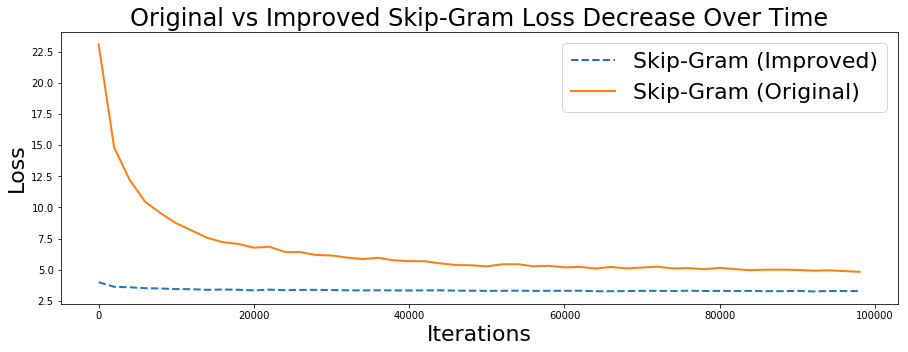

In [13]:
# Load the skip-gram losses from the calculations we did in Chapter 3
# So you need to make sure you have this csv file before running the code below
skip_loss_path = os.path.join('..','ch3','skip_losses.csv')
with open(skip_loss_path, 'rt') as f:
    reader = csv.reader(f,delimiter=',')
    for r_i,row in enumerate(reader):
        if r_i == 0:
            skip_gram_loss =  [float(s) for s in row]


pylab.figure(figsize=(15,5))  # figure in inches

# Define the x axis
x = np.arange(len(skip_gram_loss))*2000
  
# Plot the skip_gram_loss (loaded from chapter 3)
pylab.plot(x, skip_gram_loss, label="Skip-Gram (Improved)",linestyle='--',linewidth=2)    
# Plot the original skip gram loss from what we just ran
pylab.plot(x, skip_gram_loss_original, label="Skip-Gram (Original)",linewidth=2)

# Set some text around the plot
pylab.title('Original vs Improved Skip-Gram Loss Decrease Over Time',fontsize=24)
pylab.xlabel('Iterations',fontsize=22)
pylab.ylabel('Loss',fontsize=22)
pylab.legend(loc=1,fontsize=22)

# use for saving the figure if needed
pylab.savefig('loss_skipgram_original_vs_impr.jpg')
pylab.show()

## Plotting Skip-Gram Loss vs CBOW Loss

Here we compare the skip-gram loss and CBOW loss to compare which loss decreases quicker. Refer the text for an analysis of the results.

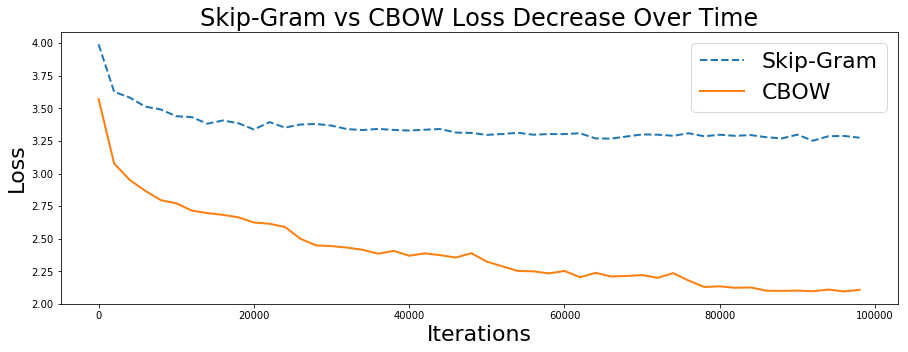

In [14]:
# Load the skip-gram losses from the calculations we did in Chapter 3
# So you need to make sure you have this csv file before running the code below
cbow_loss_path = os.path.join('..','ch3','cbow_losses.csv')
with open(cbow_loss_path, 'rt') as f:
    reader = csv.reader(f,delimiter=',')
    for r_i,row in enumerate(reader):
        if r_i == 0:
            cbow_loss =  [float(s) for s in row]

pylab.figure(figsize=(15,5))  # in inches

# Define the x axis
x = np.arange(len(skip_gram_loss))*2000

# Plot the skip_gram_loss (loaded from chapter 3)
pylab.plot(x, skip_gram_loss, label="Skip-Gram",linestyle='--',linewidth=2)    
# Plot the cbow_loss (loaded from chapter 3)
pylab.plot(x, cbow_loss, label="CBOW",linewidth=2)

# Set some text around the plot
pylab.title('Skip-Gram vs CBOW Loss Decrease Over Time',fontsize=24)
pylab.xlabel('Iterations',fontsize=22)
pylab.ylabel('Loss',fontsize=22)
pylab.legend(loc=1,fontsize=22)

# use for saving the figure if needed
pylab.savefig('loss_skipgram_vs_cbow.png')
pylab.show()


## Plotting TSNE Embeddings for Skip-Gram and CBOW Side by Side

Loss itself is not an adequate measure of performance. Therefore we visualize the learned embeddings by projecting the embeddings to a two dimensional canvas with a technique known as t-SNE.

In [15]:
def find_clustered_embeddings(embeddings,distance_threshold,sample_threshold):
    ''' 
    Find only the closely clustered embeddings. 
    This gets rid of more sparsly distributed word embeddings and make the visualization clearer
    This is useful for t-SNE visualization
    
    distance_threshold: maximum distance between two points to qualify as neighbors
    sample_threshold: number of neighbors required to be considered a cluster
    '''
    
    # calculate cosine similarity
    cosine_sim = np.dot(embeddings,np.transpose(embeddings))
    norm = np.dot(np.sum(embeddings**2,axis=1).reshape(-1,1),np.sum(np.transpose(embeddings)**2,axis=0).reshape(1,-1))
    assert cosine_sim.shape == norm.shape
    cosine_sim /= norm
    
    # make all the diagonal entries zero otherwise this will be picked as highest
    np.fill_diagonal(cosine_sim, -1.0)
    
    argmax_cos_sim = np.argmax(cosine_sim, axis=1)
    mod_cos_sim = cosine_sim
    # find the maximums in a loop to count if there are more than n items above threshold
    for _ in range(sample_threshold-1):
        argmax_cos_sim = np.argmax(cosine_sim, axis=1)
        mod_cos_sim[np.arange(mod_cos_sim.shape[0]),argmax_cos_sim] = -1
    
    max_cosine_sim = np.max(mod_cos_sim,axis=1)

    return np.where(max_cosine_sim>distance_threshold)[0]

### Fitting the skip-gram and CBOW embeddings to a t-SNE 
We fit skip-gram and CBOW embeddings to a t-SNE to get their mapping on a two dimensional surface. We only visualize densely clustered data points to avoid clutter in the visualization. This is achieved with the above function `find_clustered_embeddings`.

In [16]:
# Load the previously saved embeddings from Chapter 3 exercise
skip_emb_path = os.path.join('..','ch3','skip_embeddings.npy')
cbow_emb_path = os.path.join('..','ch3','cbow_embeddings.npy')

skip_gram_final_embeddings = np.load(skip_emb_path)
cbow_final_embeddings = np.load(cbow_emb_path)

num_points = 1000 # we will use a large sample space to build the T-SNE manifold and then prune it using cosine similarity

# Create a t-SNE object from scikit-learn
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

print('Fitting embeddings to T-SNE (skip-gram and CBOW)')
# Get the T-SNE manifold for skip-gram embeddings
print('\tSkip-gram')
sg_selected_embeddings = skip_gram_final_embeddings[:num_points, :]
sg_two_d_embeddings = tsne.fit_transform(sg_selected_embeddings)

# Get the T-SNE manifold for CBOW embeddings
print('\tCBOW')
cbow_selected_embeddings = cbow_final_embeddings[:num_points, :]
cbow_two_d_embeddings = tsne.fit_transform(cbow_selected_embeddings)

print('Pruning the T-SNE embeddings (skip-gram and CBOW)')
# Prune the embeddings by getting ones only more than n-many sample above the similarity threshold
# this unclutters the visualization
# Prune skip-gram
print('\tSkip-gram')
sg_selected_ids = find_clustered_embeddings(sg_selected_embeddings,.3,10)
sg_two_d_embeddings = sg_two_d_embeddings[sg_selected_ids,:]
# Prune CBOW
print('\tCBOW')
cbow_selected_ids = find_clustered_embeddings(cbow_selected_embeddings,.3,10)
cbow_two_d_embeddings = cbow_two_d_embeddings[cbow_selected_ids,:]

# Some stats about pruning
print('Out of ',num_points,' samples (skip-gram), ', sg_selected_ids.shape[0],' samples were selected by pruning')
print('Out of ',num_points,' samples (CBOW), ', cbow_selected_ids.shape[0],' samples were selected by pruning')


Fitting embeddings to T-SNE (skip-gram and CBOW)
	Skip-gram
	CBOW
Pruning the T-SNE embeddings (skip-gram and CBOW)
	Skip-gram
	CBOW
Out of  1000  samples (skip-gram),  123  samples were selected by pruning
Out of  1000  samples (CBOW),  123  samples were selected by pruning


### Plotting the Embeddings
Here we plot the embeddings side by side, each embedding layer on its own subplot. We also use different colors for data points to improve clarity.

Define Label colors for %d 20
Running K-Means for skip-gram
Running K-Means for CBOW
K-Means ran successfully
Plotting results


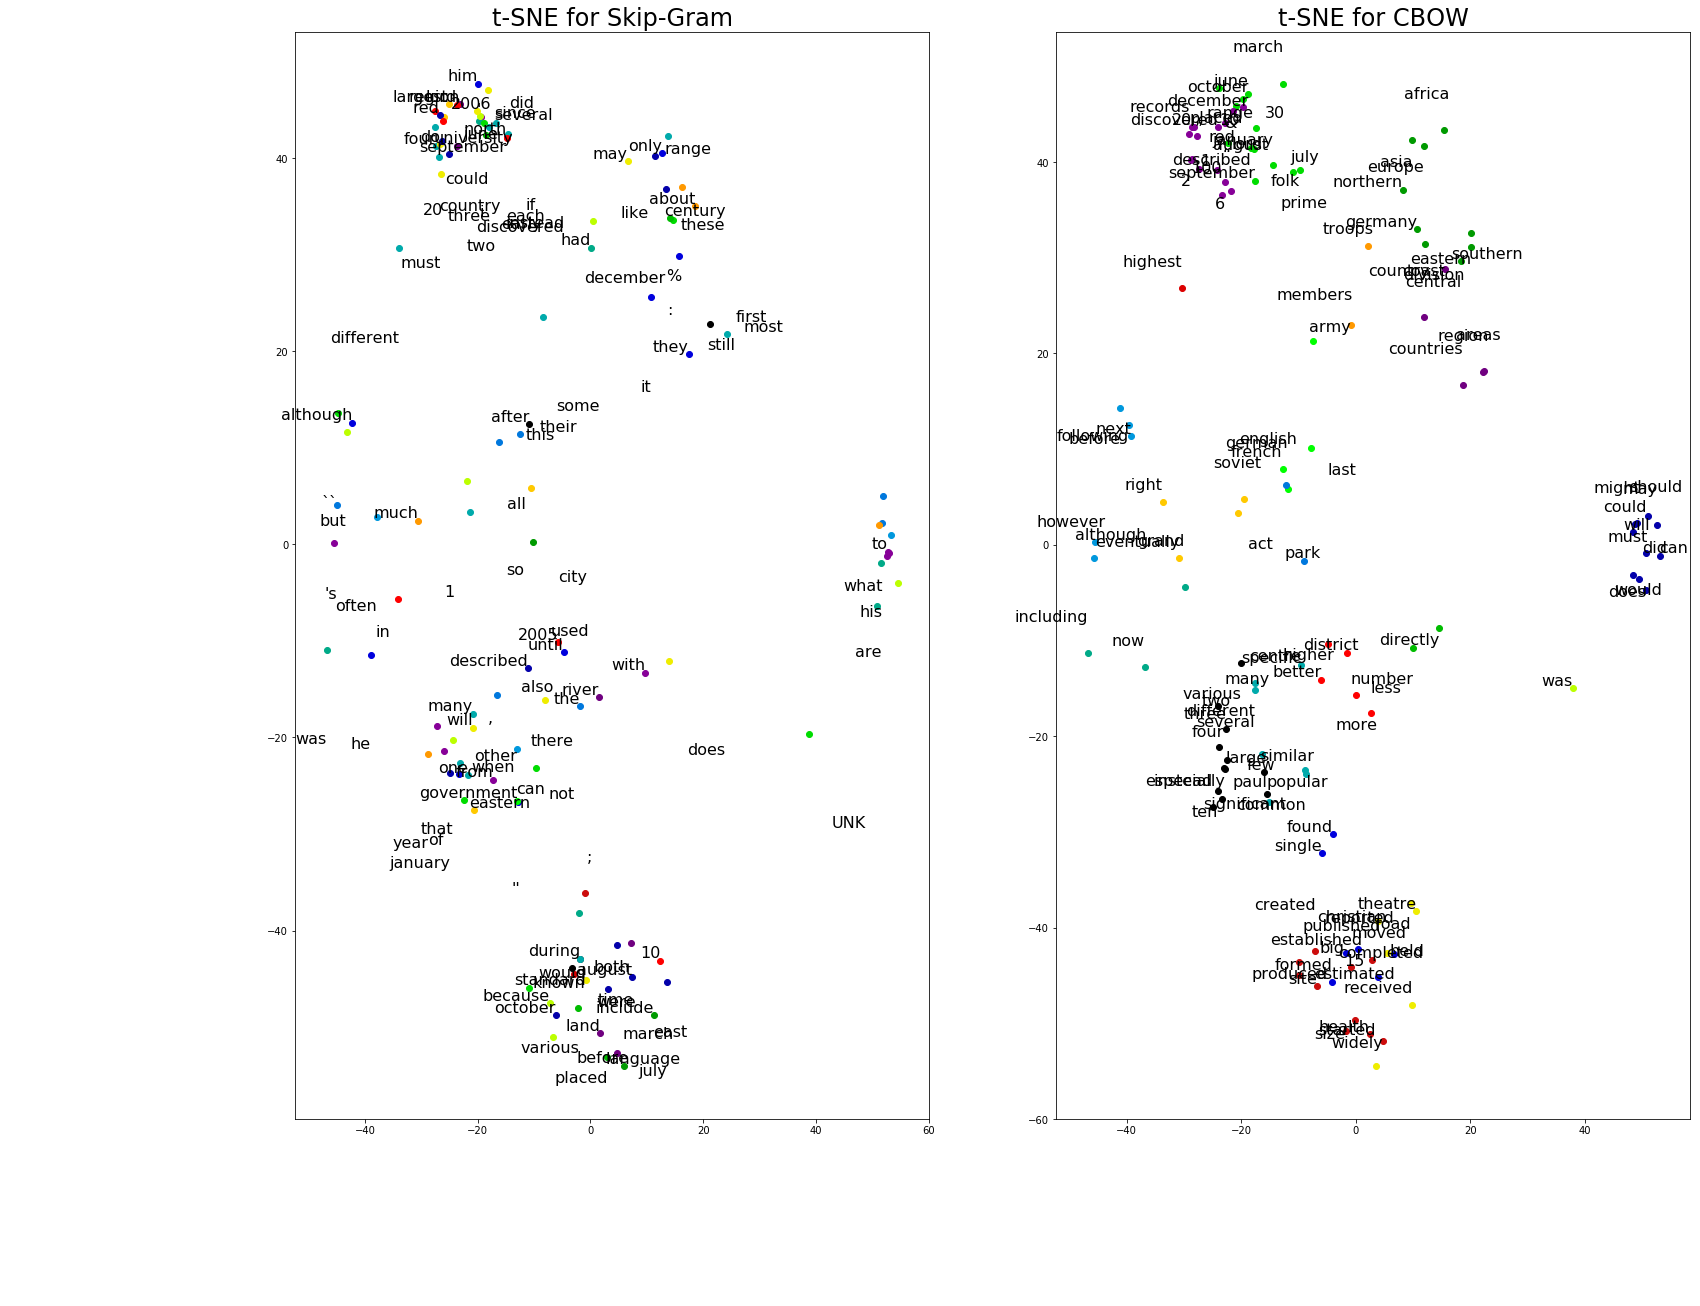

In [17]:
def plot_embeddings_side_by_side(sg_embeddings, cbow_embeddings, sg_labels, cbow_labels):
  ''' Plots word embeddings of skip-gram and CBOW side by side as subplots
  '''
  # number of clusters for each word embedding 
  # clustering is used to assign different colors as a visual aid
  n_clusters = 20 
    
  # automatically build a discrete set of colors, each for cluster
  print('Define Label colors for %d',n_clusters)
  label_colors = [pylab.cm.spectral(float(i) /n_clusters) for i in range(n_clusters)]
  
  # Make sure number of embeddings and their labels are the same
  assert sg_embeddings.shape[0] >= len(sg_labels), 'More labels than embeddings'
  assert cbow_embeddings.shape[0] >= len(cbow_labels), 'More labels than embeddings'
  
  print('Running K-Means for skip-gram')
  # Define K-Means
  sg_kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=0).fit(sg_embeddings)
  sg_kmeans_labels = sg_kmeans.labels_
  sg_cluster_centroids = sg_kmeans.cluster_centers_

  print('Running K-Means for CBOW')
  cbow_kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=0).fit(cbow_embeddings)
  cbow_kmeans_labels = cbow_kmeans.labels_
  cbow_cluster_centroids = cbow_kmeans.cluster_centers_
    
  print('K-Means ran successfully')

  print('Plotting results')
  pylab.figure(figsize=(25,20))  # in inches

  # Get the first subplot
  pylab.subplot(1, 2, 1) 

  # Plot all the embeddings and their corresponding words for skip-gram
  for i, (label,klabel) in enumerate(zip(sg_labels,sg_kmeans_labels)):
    center = sg_cluster_centroids[klabel,:]
    x, y = cbow_embeddings[i,:]
    
    # This is just to spread the data points around a bit
    # So that the labels are clearer
    # We repel datapoints from the cluster centroid
    if x < center[0]:
        x += -abs(np.random.normal(scale=2.0))
    else:
        x += abs(np.random.normal(scale=2.0))
        
    if y < center[1]:
        y += -abs(np.random.normal(scale=2.0))
    else:
        y += abs(np.random.normal(scale=2.0))
        
    pylab.scatter(x, y, c=label_colors[klabel])    
    x = x if np.random.random()<0.5 else x + 10
    y = y if np.random.random()<0.5 else y - 10
    pylab.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points',
                   ha='right', va='bottom',fontsize=16)
  pylab.title('t-SNE for Skip-Gram',fontsize=24)

  # Get the second subplot
  pylab.subplot(1, 2, 2)  

  # Plot all the embeddings and their corresponding words for CBOW
  for i, (label,klabel) in enumerate(zip(cbow_labels,cbow_kmeans_labels)):
    center = cbow_cluster_centroids[klabel,:]
    x, y = cbow_embeddings[i,:]  
    
    # This is just to spread the data points around a bit
    # So that the labels are clearer
    # We repel datapoints from the cluster centroid
    if x < center[0]:
        x += -abs(np.random.normal(scale=2.0))
    else:
        x += abs(np.random.normal(scale=2.0))
        
    if y < center[1]:
        y += -abs(np.random.normal(scale=2.0))
    else:
        y += abs(np.random.normal(scale=2.0))
        
    pylab.scatter(x, y, c=label_colors[klabel])  
    x = x if np.random.random()<0.5 else x + np.random.randint(0,10)
    y = y + np.random.randint(0,5) if np.random.random()<0.5 else y - np.random.randint(0,5)
    pylab.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points',
                   ha='right', va='bottom',fontsize=16)

  pylab.title('t-SNE for CBOW',fontsize=24)
  # use for saving the figure if needed
  pylab.savefig('tsne_skip_vs_cbow.png')
  pylab.show()

# Run the function
sg_words = [reverse_dictionary[i] for i in sg_selected_ids]
cbow_words = [reverse_dictionary[i] for i in cbow_selected_ids]
plot_embeddings_side_by_side(sg_two_d_embeddings, cbow_two_d_embeddings, sg_words,cbow_words)


# CBOW Algorithm

## Changing the data generation process
We need to define a new data generator for CBOW. Shape of the new input array is (batch_size, context_window*2). That is, a batch in CBOW captures all the words in the context of a given word.

In [18]:
data_index = 0

def generate_batch_cbow(batch_size, window_size):
    # window_size is the amount of words we're looking at from each side of a given word
    # creates a single batch
    
    # data_index is updated by 1 everytime we read a set of data point
    global data_index

    # span defines the total window size, where
    # data we consider at an instance looks as follows. 
    # [ skip_window target skip_window ]
    # e.g if skip_window = 2 then span = 5
    span = 2 * window_size + 1 # [ skip_window target skip_window ]

    # two numpy arras to hold target words (batch)
    # and context words (labels)
    # Note that batch has span-1=2*window_size columns
    batch = np.ndarray(shape=(batch_size,span-1), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    # The buffer holds the data contained within the span
    buffer = collections.deque(maxlen=span)

    # Fill the buffer and update the data_index
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)

    # Here we do the batch reading
    # We iterate through each batch index
    # For each batch index, we iterate through span elements
    # to fill in the columns of batch array
    for i in range(batch_size):
        target = window_size  # target label at the center of the buffer
        target_to_avoid = [ window_size ] # we only need to know the words around a given word, not the word itself

        # add selected target to avoid_list for next time
        col_idx = 0
        for j in range(span):
            # ignore the target word when creating the batch
            if j==span//2:
                continue
            batch[i,col_idx] = buffer[j] 
            col_idx += 1
        labels[i, 0] = buffer[target]

        # Everytime we read a data point,
        # we need to move the span by 1
        # to create a fresh new span
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)

    return batch, labels

for window_size in [1,2]:
    data_index = 0
    batch, labels = generate_batch_cbow(batch_size=8, window_size=window_size)
    print('\nwith window_size = %d:' % (window_size))
    print('    batch:', [[reverse_dictionary[bii] for bii in bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])


with window_size = 1:
    batch: [['propaganda', 'a'], ['is', 'concerted'], ['a', 'set'], ['concerted', 'of'], ['set', 'messages'], ['of', 'aimed'], ['messages', 'at'], ['aimed', 'influencing']]
    labels: ['is', 'a', 'concerted', 'set', 'of', 'messages', 'aimed', 'at']

with window_size = 2:
    batch: [['propaganda', 'is', 'concerted', 'set'], ['is', 'a', 'set', 'of'], ['a', 'concerted', 'of', 'messages'], ['concerted', 'set', 'messages', 'aimed'], ['set', 'of', 'aimed', 'at'], ['of', 'messages', 'at', 'influencing'], ['messages', 'aimed', 'influencing', 'the'], ['aimed', 'at', 'the', 'opinions']]
    labels: ['a', 'concerted', 'set', 'of', 'messages', 'aimed', 'at', 'influencing']


# Using Candidate Sampling with the Unigram Distribution for Negative Sampling

## Unigram distribution
The unigram distribution $U(w_i)$ for a given word $w_i$ is given by,

$ P(w_i|w_1,...,w_{i-1}) \simeq P(w_i) = \frac{count(w_i)}{\sum_{w_j \in corpus}count(w_j)} = U(w_i) $

The original paper found that if words are sampled the noise for the negative sampling with a particular distribution gives the best results. And the distribution is given by,

$ U(w)^{3/4} / Z $ where $Z$ is a constant.

In [19]:
# Creating vocabulary file and unigram counts
# Requried by the tf.nn.fixed_unigram_candidate_sampler

# vocabulary file: Each valid line in this file (which should have a CSV-like format) corresponds to a valid word ID. IDs are in sequential order.
# unigrams: A list of unigram counts or probabilities, one per ID in sequential order. Exactly one of vocab_file and unigrams should be passed to this operation.

word_count_dictionary = {}
unigrams = [0 for _ in range(vocabulary_size)]
for word,w_count in count:
    w_idx = dictionary[word]
    unigrams[w_idx] = w_count*1.0/token_count
    word_count_dictionary[w_idx] = w_count
print('First 10 Unigram probabilities')
print(unigrams[:10])

First 10 Unigram probabilities
[0.020597949103141815, 0.06751836004435337, 0.0547611125957731, 0.03599217447562499, 0.03461699391063737, 0.026378111863097367, 0.02315338634866199, 0.019532861190981958, 0.01753065066485412, 0.009183146910709386]


### Defining Hyperparameters

Here we define several hyperparameters including `batch_size` (amount of samples in a single batch) `embedding_size` (size of embedding vectors) `window_size` (context window size).

In [20]:
batch_size = 128 # Data points in a single batch
embedding_size = 128 # Dimension of the embedding vector.
# How many words to consider left and right.
# Skip gram by design does not require to have all the context words in a given step
# However, for CBOW that's a requirement, so we limit the window size
window_size = 2 

# We pick a random validation set to sample nearest neighbors
valid_size = 16 # Random set of words to evaluate similarity on.
# We sample valid datapoints randomly from a large window without always being deterministic
valid_window = 50

# When selecting valid examples, we select some of the most frequent words as well as
# some moderately rare words as well
valid_examples = np.array(random.sample(range(valid_window), valid_size))
valid_examples = np.append(valid_examples,random.sample(range(1000, 1000+valid_window), valid_size),axis=0)

num_sampled = 32 # Number of negative examples to sample.

### Defining Inputs and Outputs

Here we define placeholders for feeding in training inputs and outputs (each of size `batch_size`) and a constant tensor to contain validation examples.

In [21]:
tf.reset_default_graph()

# Training input data (target word IDs). Note that it has 2*window_size columns
train_dataset = tf.placeholder(tf.int32, shape=[batch_size,2*window_size])
# Training input label data (context word IDs)
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
# Validation input data, we don't need a placeholder
# as we have already defined the IDs of the words selected
# as validation data
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

### Defining Model Parameters and Other Variables
We now define several TensorFlow variables such as an embedding layer (`embeddings`) and neural network parameters (`softmax_weights` and `softmax_biases`)

In [22]:
# Variables.

# Embedding layer, contains the word embeddings
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0,dtype=tf.float32))

# Softmax Weights and Biases
softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                 stddev=0.5 / math.sqrt(embedding_size),dtype=tf.float32))
softmax_biases = tf.Variable(tf.random_uniform([vocabulary_size],0.0,0.01))

### Defining the Model Computations

We first defing a lookup function to fetch the corresponding embedding vectors for a set of given inputs. Concretely, we define $2\times$`window_size` embedding lookups. We then concatenate all these looked up embedding vectors to form a matrix of size `[batch_size, embedding_size, 2*window_size]`. Thereafter, we average these embedding lookups to produce an average embeddings of size `[batch_size, embedding_size]`. With that, we define negative sampling loss function `tf.nn.sampled_softmax_loss` which takes in the embedding vectors and previously defined neural network parameters.

In [23]:

# Model.
# Look up embeddings for a batch of inputs.
# Here we do embedding lookups for each column in the input placeholder
# and then average them to produce an embedding_size word vector
stacked_embedings = None
print('Defining %d embedding lookups representing each word in the context'%(2*window_size))
for i in range(2*window_size):
    embedding_i = tf.nn.embedding_lookup(embeddings, train_dataset[:,i])        
    x_size,y_size = embedding_i.get_shape().as_list()
    if stacked_embedings is None:
        stacked_embedings = tf.reshape(embedding_i,[x_size,y_size,1])
    else:
        stacked_embedings = tf.concat(axis=2,values=[stacked_embedings,tf.reshape(embedding_i,[x_size,y_size,1])])

assert stacked_embedings.get_shape().as_list()[2]==2*window_size
print("Stacked embedding size: %s"%stacked_embedings.get_shape().as_list())
mean_embeddings =  tf.reduce_mean(stacked_embedings,2,keepdims=False)
print("Reduced mean embedding size: %s"%mean_embeddings.get_shape().as_list())

# Compute the softmax loss, using a sample of the negative labels each time.
# inputs are embeddings of the train words
# with this loss we optimize weights, biases, embeddings

# However, unlike at the previous instance (Chapter 3) we use a different sample to sampel negative classes
# Particularly we use a unigram candidate sampler, to which we provide
# the unigram probabilities we computed earlier. For details about the passed arguments
# Refer the text in Chapter 4
candidate_sampler = tf.nn.fixed_unigram_candidate_sampler(true_classes = tf.cast(train_labels,dtype=tf.int64), num_true = 1, 
                                      num_sampled = num_sampled, 
                                      unique = True, range_max = vocabulary_size, 
                                      distortion=0.75, 
                                      num_reserved_ids=0, 
                                      unigrams=unigrams, name='unigram_sampler')

# The loss is very similar to what we defined in Chapter 3, except for
# passing the above defined sampler to the function.
loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=mean_embeddings,
                           labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size,
                              sampled_values=candidate_sampler))


Defining 4 embedding lookups representing each word in the context
Stacked embedding size: [128, 128, 4]
Reduced mean embedding size: [128, 128]
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



### Model Parameter Optimizer

We then define a learning rate as a constant and an optimizer which uses the Adagrad method. Feel free to experiment with other optimizers listed [here](https://www.tensorflow.org/api_guides/python/train).

In [24]:
optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

### Calculating Word Similarities 
We calculate the similarity between two given words in terms of the cosine distance. To do this efficiently we use matrix operations to do so, as shown below.

In [25]:
# Compute the similarity between minibatch examples and all embeddings.
# We use the cosine distance:
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))



## Running CBOW with Unigram Candidate Sampling

Here we run the CBOW algorithm with unigram based candidate sampling, we defined above. Specifically, we first initialize variables, and then train the algorithm for many steps (`num_steps`). And every few steps we evaluate the algorithm on a fixed validation set and print out the words that appear to be closest for a given set of words.

In [26]:
num_steps = 100001
cbow_loss_unigram = []

# ConfigProto is a way of providing various configuration settings 
# required to execute the graph
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as session:
    
    # Initialize the variables in the graph
    tf.global_variables_initializer().run()
    print('Initialized')
    
    average_loss = 0
    
    # Train the Word2vec model for num_step iterations
    for step in range(num_steps):
        
        # Generate a single batch of data
        batch_data, batch_labels = generate_batch_cbow(batch_size, window_size)
        
        # Populate the feed_dict and run the optimizer (minimize loss)
        # and compute the loss
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        
        # Update the average loss variable
        average_loss += l
        
        if (step+1) % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
                # The average loss is an estimate of the loss over the last 2000 batches.
            cbow_loss_unigram.append(average_loss)
            print('Average loss at step %d: %f' % (step+1, average_loss))
            average_loss = 0
            
        # Evaluating validation set word similarities
        if (step+1) % 10000 == 0:
            sim = similarity.eval()
            # Here we compute the top_k closest words for a given validation word
            # in terms of the cosine distance
            # We do this for all the words in the validation set
            # Note: This is an expensive step
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    cbow_final_embeddings = normalized_embeddings.eval()
    
    
with open('cbow_unigram_losses.csv', 'wt') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(cbow_loss_unigram)


Initialized
Average loss at step 2000: 3.432433
Average loss at step 4000: 2.900289
Average loss at step 6000: 2.774288
Average loss at step 8000: 2.691287
Average loss at step 10000: 2.629643
Nearest to have: had, has, challenges, be, designate, albisaurus, magister, depose,
Nearest to other: year., tian, rough, striped, gebhart, edgeworth, antisubmarine, kilogram,
Nearest to had: has, have, would, was, blisters, duma, sweetener, pertains,
Nearest to 's: voivode, toucouleurs, glorified, zero-fare, his, osmotic, dirac, oligodendrocytes,
Nearest to their: its, his, the, outweighed, overruns, jinjur, gsm, enough,
Nearest to were: are, was, unethical, pressurised, documenting, cheng, stalks, becomes,
Nearest to on: knowable, feynman, herrn, recombination, virions, monologues, fuerza, pope,
Nearest to is: was, are, has, 19°, intermarriages, slovensko, cuticle, esoteric,
Nearest to ,: ;, ., yudenich, describing, forelimb, well-represented, 20,700, ''paradise,
Nearest to which: that, who, bu

Average loss at step 62000: 2.086671
Average loss at step 64000: 2.035246
Average loss at step 66000: 2.064289
Average loss at step 68000: 2.039306
Average loss at step 70000: 2.033401
Nearest to have: has, had, having, allow, mean, limestones, cyclonic, gesner,
Nearest to other: various, tana, individual, gebhart, prescribed, year., technologies, antisubmarine,
Nearest to had: has, have, having, 1740, bug, humanitarian, sweetener, was,
Nearest to 's: s, oligodendrocytes, dirac, glorified, toucouleurs, desist, my, grand-bassam,
Nearest to their: its, his, her, our, op, human-caused, tempos, powiśle,
Nearest to were: are, was, grows, been, stalks, becomes, being, be,
Nearest to on: upon, knowable, distilling, el-hol, constant-current, feynman, cpgb, claire,
Nearest to is: was, remains, contains, are, has, 19°, intermarriages, esoteric,
Nearest to ,: —, ;, ., prorogued, –, strongholds, vinohrady, halfpence,
Nearest to which: where, but, that, who, primarily, pali, whom, irises,
Nearest t

# Subsampling the Frequent words

This is important as the most-frequent words such as "in", "a", "the" do not add a significant value to word embeddings. For example, a training input output tuple (France, Paris) has more information than (France, The). So if we can avoid such frequent words, it can help to boost the quality of word vectors. 

Therefore we sample each word $w_i$ with a probability $P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}}$

## Generating Word Sequence with Subsampling

In [27]:

subsampled_data = []
drop_count = 0
drop_examples = []

# Here we traverse through the data and drop irrelavent words
# according to the subsampling probability 
for w_i in data:
    # Note that the paper uses t=1e-5
    # This is fine when using a normalized frequency of words
    # But we are using raw frequencies so we set t=1e5
    p_w_i = 1 - np.sqrt(1e5/word_count_dictionary[w_i])
    
    if np.random.random() < p_w_i:
        drop_count += 1
        drop_examples.append(reverse_dictionary[w_i])
    else:
        subsampled_data.append(w_i)
        
# Print some statistics
print('Dropped %d%% words (%d words) in total...'%(drop_count*100.0/len(data),drop_count))
print('Dropped Examples: ', drop_examples[:20])
print('\nOriginal data: ',[reverse_dictionary[w_i] for w_i in data[:20]])
print('\nSubsampled data: ',[reverse_dictionary[w_i] for w_i in subsampled_data[:20]])

Dropped 4% words (143768 words) in total...
Dropped Examples:  ['the', 'of', 'the', 'the', 'the', 'the', 'of', 'the', 'the', 'of', 'the', 'the', ',', 'the', 'the', '.', 'the', ',', ',', 'the']

Original data:  ['propaganda', 'is', 'a', 'concerted', 'set', 'of', 'messages', 'aimed', 'at', 'influencing', 'the', 'opinions', 'or', 'behavior', 'of', 'large', 'numbers', 'of', 'people', '.']

Subsampled data:  ['propaganda', 'is', 'a', 'concerted', 'set', 'of', 'messages', 'aimed', 'at', 'influencing', 'the', 'opinions', 'or', 'behavior', 'of', 'large', 'numbers', 'of', 'people', '.']


## Running CBOW with Unigram Sampling + Subsampling

Here we run the CBOW with unigram sampling and subsampling which we defined above. Specifically, we first initialize variables, and then train the algorithm for many steps (`num_steps`). And every few steps we evaluate the algorithm on a fixed validation set and print out the words that appear to be closest for a given set of words.

In [28]:
num_steps = 100001
cbow_loss_unigram_subsampled = []


# ConfigProto is a way of providing various configuration settings 
# required to execute the graph
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as session:
    
    # Initialize the variables in the graph
    tf.global_variables_initializer().run()
    print('Initialized')
    
    average_loss = 0
    
    # Train the Word2vec model for num_step iterations
    for step in range(num_steps):
        
        # Generate a single batch of data
        batch_data, batch_labels = generate_batch_cbow(batch_size, window_size)
        
        # Populate the feed_dict and run the optimizer (minimize loss)
        # and compute the loss
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        
        # Update the average loss variable
        average_loss += l
        
        if (step+1) % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
                # The average loss is an estimate of the loss over the last 2000 batches.
            cbow_loss_unigram_subsampled.append(average_loss)
            print('Average loss at step %d: %f' % (step+1, average_loss))
            average_loss = 0
            
        # Evaluating validation set word similarities
        if (step+1) % 10000 == 0:
            sim = similarity.eval()
            # Here we compute the top_k closest words for a given validation word
            # in terms of the cosine distance
            # We do this for all the words in the validation set
            # Note: This is an expensive step
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    cbow_final_embeddings = normalized_embeddings.eval()
    
    
with open('cbow_unigram_subsampled_losses.csv', 'wt') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(cbow_loss_unigram_subsampled)

Initialized
Average loss at step 2000: 3.426986
Average loss at step 4000: 2.917407
Average loss at step 6000: 2.767598
Average loss at step 8000: 2.688828
Average loss at step 10000: 2.643141
Nearest to have: has, be, had, hatred, cec, labiovelar, do, agglomeration,
Nearest to other: impeachment, idiocy, vehicles, mexican-american, meat, municipal, 38, more,
Nearest to had: has, have, was, natal, high-profile, |feb_rec_hi_°c, net, imaged,
Nearest to 's: charles, diamonds, epitheta, nep, oatmeal, -dir4, cosmopolitan, clap,
Nearest to their: its, his, the, halicarnassus, her, 1806, botany, disappointment,
Nearest to were: are, was, would, porsche, 1868, karachi, potent, bhed,
Nearest to on: puma, forfeda, marge, auto, an/sps-67, files, krenz, |sep_lo_°c,
Nearest to is: was, are, negotiation, has, negatively, accrete, macgreevy, compacted,
Nearest to ,: ;, tupolev, ., 18, grew, -, =, petros,
Nearest to which: assisi, but, reale, tamil, fritz, leftover, light-weight, hiding,
Nearest to it

Average loss at step 62000: 2.071420
Average loss at step 64000: 2.037744
Average loss at step 66000: 2.048317
Average loss at step 68000: 2.034745
Average loss at step 70000: 2.038459
Nearest to have: has, had, having, agglomeration, hatred, hold, cec, 9.,
Nearest to other: various, vehicles, individual, environmental, phagwa, these, pili, unrest,
Nearest to had: have, has, having, were, spool, was, supervisor, remi,
Nearest to 's: epitheta, s, claria, ’, typified, kampong, rdl, jacobins,
Nearest to their: its, his, her, our, halicarnassus, calderón, 1125, critiquing,
Nearest to were: are, was, potent, being, had, mileva, gediminas, winwaed,
Nearest to on: upon, toward, marge, puma, auto, furious, krenz, cornish,
Nearest to is: was, are, contains, has, became, negatively, becomes, remained,
Nearest to ,: ;, tupolev, ., m1903, anomalous, lecturers, cog, schiphol,
Nearest to which: where, but, assisi, whose, including, leftover, reale, that,
Nearest to its: their, his, 90.5, telecommuni

## Plotting CBOW (Original), Unigram based Negative Sampling and Subsampling Losses

Here we plot the losses obtained over time for all the CBOW based algorithms to see which one performs better. We provide a detailed analysis of the observations in the Chapter 4 text.

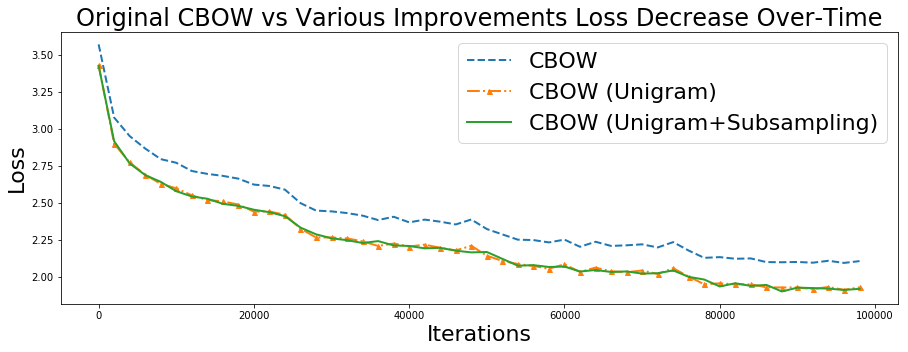

In [29]:
pylab.figure(figsize=(15,5))  # in inches

# Define the x axis
x = np.arange(len(skip_gram_loss))*2000

# Plotting standard CBOW loss, CBOW loss with unigram sampling and
# CBOW loss with unigram sampling + subsampling here in one plot
pylab.plot(x, cbow_loss, label="CBOW",linestyle='--',linewidth=2)
pylab.plot(x, cbow_loss_unigram, label="CBOW (Unigram)",linestyle='-.',linewidth=2,marker='^',markersize=5)
pylab.plot(x, cbow_loss_unigram_subsampled, label="CBOW (Unigram+Subsampling)",linewidth=2)

# Some text around the plots
pylab.title('Original CBOW vs Various Improvements Loss Decrease Over-Time',fontsize=24)
pylab.xlabel('Iterations',fontsize=22)
pylab.ylabel('Loss',fontsize=22)
pylab.legend(loc=1,fontsize=22)

# Use for saving the figure if needed
pylab.savefig('loss_cbow_vs_all_improvements.png')
pylab.show()